In [823]:
from __future__ import print_function, division
#Import BeautifulSoup
from bs4 import BeautifulSoup
#Regular expressions compiler
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import pickle

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline
# %pylab inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [743]:
#Functions:

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [744]:
with open('hosp.pickle','rb') as read_file:
    hosp = pickle.load(read_file)
    
hosp.info()
hosp.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 0 to 3112
Data columns (total 47 columns):
provider_id                                                                          2321 non-null object
start_date                                                                           2321 non-null object
end_date                                                                             2321 non-null object
avg_EXCESS                                                                           2321 non-null float64
avg_PRR                                                                              2321 non-null float64
avg_ERR                                                                              2321 non-null float64
PRR_imputed                                                                          2321 non-null int64
nod_imputed                                                                          2321 non-null int64
number_of_discharges                        

,provider_id,start_date,end_date,avg_EXCESS,avg_PRR,avg_ERR,PRR_imputed,nod_imputed,number_of_discharges,number_of_readmissions,...,safety_of_care_national_comparison_Below_the_national_average,safety_of_care_national_comparison_Same_as_the_national_average,patient_experience_national_comparison_Below_the_national_average,patient_experience_national_comparison_Same_as_the_national_average,effectiveness_of_care_national_comparison_Below_the_national_average,effectiveness_of_care_national_comparison_Same_as_the_national_average,timeliness_of_care_national_comparison_Below_the_national_average,timeliness_of_care_national_comparison_Same_as_the_national_average,efficient_use_of_medical_imaging_national_comparison_Below_the_national_average,efficient_use_of_medical_imaging_national_comparison_Same_as_the_national_average
0,010001,07/01/2014,06/30/2017,1.040567,15.120283,14.635383,0,0,3657.000000,619.0,...,0,0,1,0,0,1,0,0,0,1
1,010055,07/01/2014,06/30/2017,0.968017,13.484517,14.208433,0,0,2468.000000,328.0,...,0,0,0,1,0,1,0,0,0,0
2,010005,07/01/2014,06/30/2017,0.989000,14.458266,15.095840,1,2,2465.839517,305.0,...,1,0,0,1,0,0,0,0,1,0
3,010006,07/01/2014,06/30/2017,1.072800,14.809300,14.369283,0,0,3335.000000,533.0,...,0,0,1,0,0,1,0,0,1,0
5,010036,07/01/2014,06/30/2017,1.017240,15.958383,16.236960,1,3,1757.117337,135.0,...,0,0,1,0,0,1,0,0,0,1


### Continuous variable investigation - testing for linear assumptions

In [745]:
#Check correlation of continuous variables

hosp1 = hosp.loc[:,['avg_PRR','number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
                 '3_Year_Avg_Hourly_Wage','median_household_income','some_college_or_higher']]

hosp1.corr()

,avg_PRR,number_of_discharges,Case_Mix_Indexes,FY_Wage_Index,3_Year_Avg_Hourly_Wage,median_household_income,some_college_or_higher
avg_PRR,1.000000,0.040457,-0.034728,0.057858,0.022344,-0.090816,-0.212100
number_of_discharges,0.040457,1.000000,0.338460,0.050801,0.119797,0.083253,0.139955
Case_Mix_Indexes,-0.034728,0.338460,1.000000,0.158661,0.296827,0.120867,0.364123
FY_Wage_Index,0.057858,0.050801,0.158661,1.000000,0.890324,0.593963,0.364140
3_Year_Avg_Hourly_Wage,0.022344,0.119797,0.296827,0.890324,1.000000,0.573880,0.410033
median_household_income,-0.090816,0.083253,0.120867,0.593963,0.573880,1.000000,0.683649
some_college_or_higher,-0.212100,0.139955,0.364123,0.364140,0.410033,0.683649,1.000000


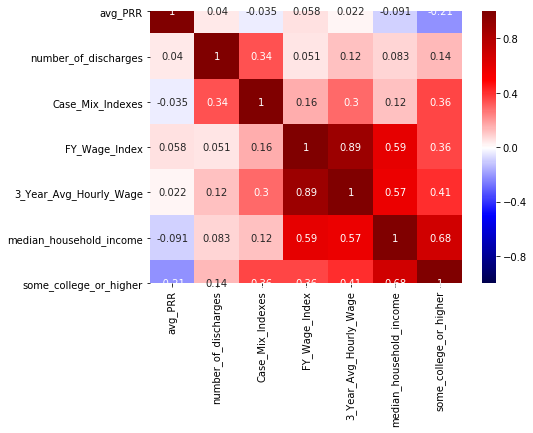

In [746]:
plt.figure(figsize=(7,5))
sns.heatmap(hosp1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

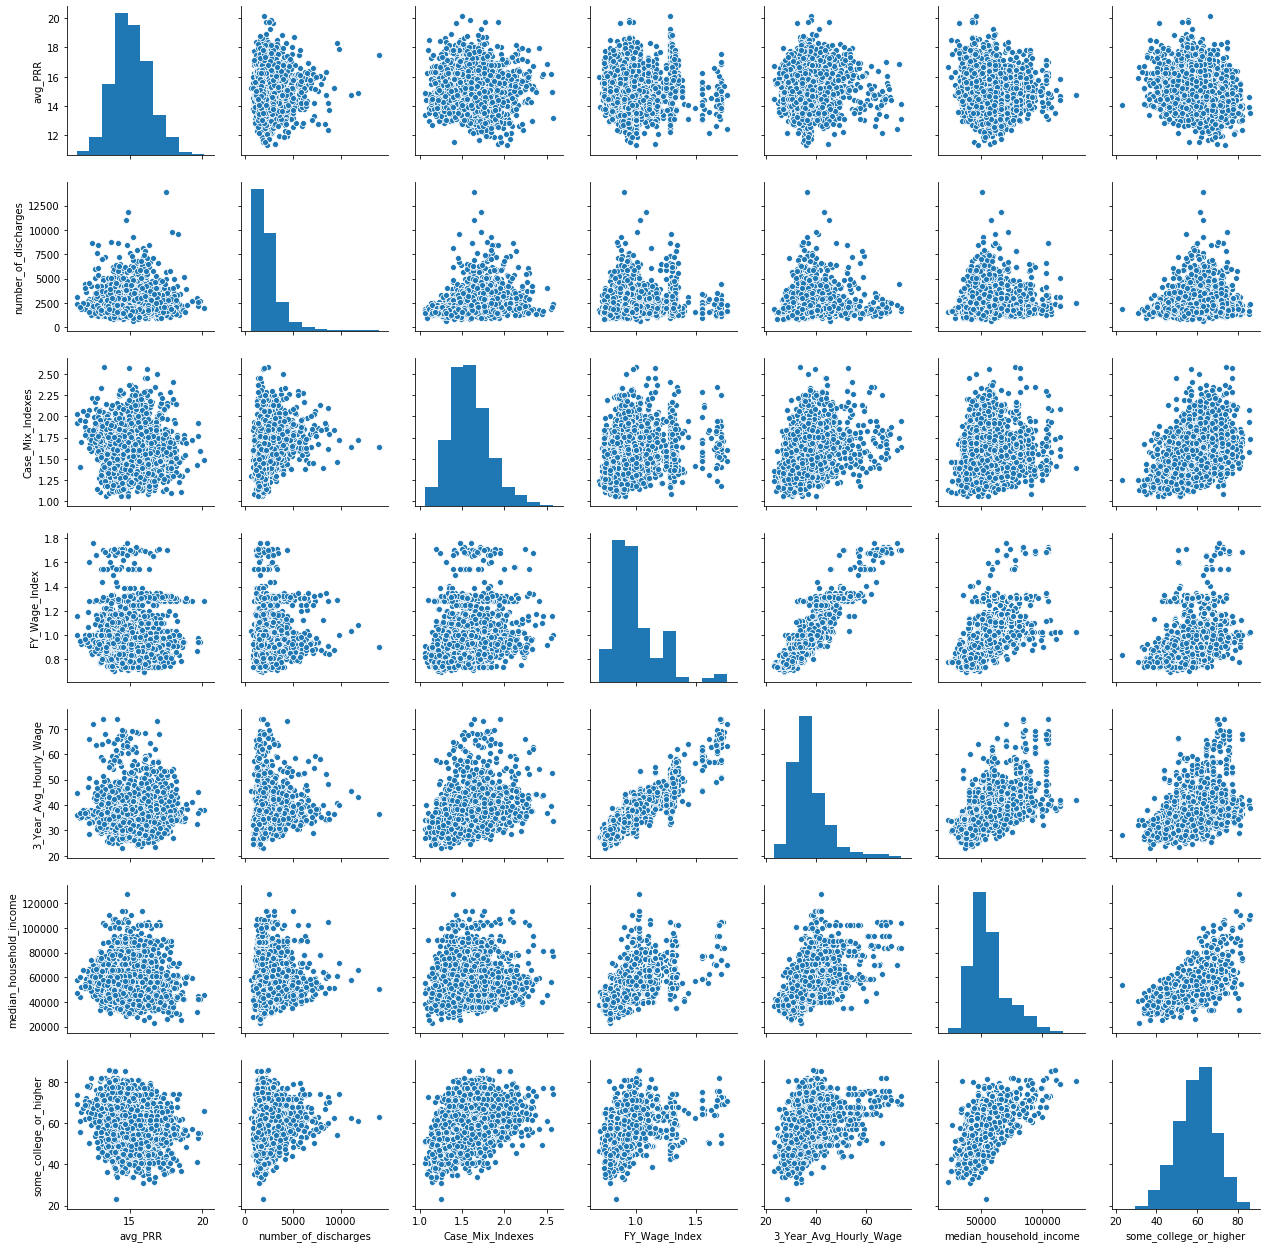

In [747]:
sns.pairplot(hosp1);

NOTES:
- high correlation of 3-yr avg and wage index- probably won't include 3-yr avg since it has the weaker correlation with PRR
- none of the pairplots suggest a polynomial transformation

### Linear regression assumptions:
1. Regression is linear in parameters & correctly specified (Duke i)
2. The error terms are normally distributed and zero population mean (Duke iv)
3. The error term has constant variance $Var({\epsilon_i})={\sigma^2}$ for every i (Duke iii, no heteroskedasticity)
4. Errors are uncorrelated across observations: $cov({\epsilon_i},{\epsilon_j})=0$ for two observations i and j (Duke ii, no serial correlation)
5. No independent variable is a perfect linear function of any other independent variable (Duke i, no perfect multi-collinearity)

### Check model of continuous variables first with simple linear regression

In [748]:
# Define the model
# lm1 = smf.ols('weighted_avg_PRR ~ FY_2017_Wage_Index + Case_Mix_Indexes + median_household_income', data=hosp)
lm1 = smf.ols('avg_PRR ~ Case_Mix_Indexes + number_of_discharges + FY_Wage_Index + median_household_income + some_college_or_higher', data=hosp)
# Fit the model
fit1 = lm1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     35.66
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           2.91e-35
Time:                        18:35:23   Log-Likelihood:                -3741.1
No. Observations:                2321   AIC:                             7494.
Df Residuals:                    2315   BIC:                             7529.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  16.0244      0.219     73.084      0.000      15.594      16.454
Case_Mix_Indexes            0.1323      0.124      1.066      0.286      -0.111       0.376
number_of_discharges     6.626e-05   2.19e-05      3.021      0.003    2.33e-05       0.000
FY_Wage_Index               1.0028      0.169      5.950      0.000       0.672       1.333
median_household_income  9.863e-07   2.73e-06      0.361      0.718   -4.36e-06    6.34e-06
some_college_or_higher     -0.0391      0.004     -9.761      0.000      -0.047      -0.031
==============================================================================
Omnibus:                       38.072   Durbin-Watson:                   1.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.062
Skew:                           0.298   Prob(JB):                     2.00e-09
Kurtosis:                       3.245   Cond. No.                     5.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

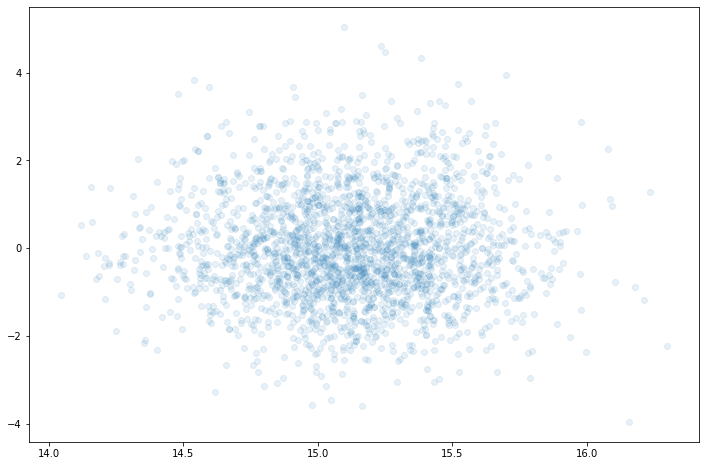

In [749]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit1.predict(), fit1.resid,alpha=0.1);

NOTES: poor R^2, residuals are clustered. Try investigating some to see if any features can be transformed (polynomials/interactions)

In [750]:
#polynomial terms
hosp['CMI2'] = hosp['Case_Mix_Indexes']**2
hosp['nod2'] = hosp['number_of_discharges']**2
hosp['FWI2'] = hosp['FY_Wage_Index']**2
hosp['MHI2'] = hosp['median_household_income']**2
hosp['SCH2'] = hosp['some_college_or_higher']**2
#interactions
hosp['CMIxNOD'] = hosp['Case_Mix_Indexes']*hosp['number_of_discharges']
hosp['FWIxMHI'] = hosp['FY_Wage_Index']*hosp['median_household_income']
hosp['MHIxSCH'] = hosp['median_household_income']*hosp['some_college_or_higher']

lm2 = smf.ols('avg_PRR ~ Case_Mix_Indexes + number_of_discharges + FY_Wage_Index + median_household_income + some_college_or_higher + FWI2 + nod2 + MHI2 + SCH2 + CMIxNOD + FWIxMHI + MHIxSCH', data=hosp)
# Fit the model
fit2 = lm2.fit()
# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     24.45
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           3.40e-52
Time:                        18:35:24   Log-Likelihood:                -3688.3
No. Observations:                2321   AIC:                             7403.
Df Residuals:                    2308   BIC:                             7477.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  10.1131      0.911     11.107      0.000       8.328      11.899
Case_Mix_Indexes            1.2853      0.258      4.989      0.000       0.780       1.790
number_of_discharges        0.0009      0.000      5.074      0.000       0.001       0.001
FY_Wage_Index               6.4202      1.238      5.187      0.000       3.993       8.847
median_household_income    -0.0001   1.87e-05     -6.674      0.000      -0.000   -8.82e-05
some_college_or_higher      0.1266      0.029      4.408      0.000       0.070       0.183
FWI2                       -2.8197      0.716     -3.941      0.000      -4.223      -1.417
nod2                     3.361e-09   6.92e-09      0.486      0.627   -1.02e-08    1.69e-08
MHI2                     1.391e-10   1.53e-10      0.912      0.362    -1.6e-10    4.38e-10
SCH2                       -0.0021      0.000     -5.967      0.000      -0.003      -0.001
CMIxNOD                    -0.0005   9.84e-05     -5.042      0.000      -0.001      -0.000
FWIxMHI                  1.599e-05   1.25e-05      1.277      0.202   -8.57e-06    4.06e-05
MHIxSCH                  1.402e-06   3.95e-07      3.552      0.000    6.28e-07    2.18e-06
==============================================================================
Omnibus:                       38.460   Durbin-Watson:                   1.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.558
Skew:                           0.298   Prob(JB):                     1.56e-09
Kurtosis:                       3.253   Cond. No.                     2.33e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

NOTES: over 50% improvement with interaction and some polynomial terms but there is colinearity - check w/ VIF

### VIF

In [751]:
#keep continuous variables for multicolinearity test
X_vif = hosp.loc[:,['number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
                    'median_household_income','some_college_or_higher']]
# X_vif = hosp.loc[:,['number_of_discharges','Case_Mix_Indexes','FY_Wage_Index',
#                     'median_household_income','some_college_or_higher',
#                     'FWI2', 'MHI2', 'SCH2', 'CMIxNOD', 'FWIxMHI', 'MHIxSCH']]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
# X_vif.info()

In [752]:
vif.round(1)

,VIF Factor,features
0,5.4,number_of_discharges
1,49.4,Case_Mix_Indexes
2,38.3,FY_Wage_Index
3,38.1,median_household_income
4,77.9,some_college_or_higher


### Split data into train/validate/test sets

,
                  'hospital_overall_rating_2','hospital_overall_rating_3','hospital_overall_rating_4',
                  'hospital_overall_rating_5','mortality_national_comparison_Below_the_national_average',
                  'mortality_national_comparison_Same_as_the_national_average','FWI2','MHI2','MHIxSCH'

In [753]:
#drop data that is not for the model
# hosp = hosp.drop(['avg_ERR','avg_EXCESS',
#                   'number_of_readmissions','measure_name',
#                   'provider_id','start_date','end_date','hospital_name','state',
#                   'zip_code','county_name','hospital_type','county_st','3_Year_Avg_Hourly_Wage',
#                   'PRR_imputed','nod_imputed'
#                  ],axis=1)

#drop all continuous variables except number of discharges 
hosp = hosp.drop(['avg_ERR','avg_EXCESS',
                  'number_of_readmissions','measure_name',
                  'provider_id','start_date','end_date','hospital_name','state',
                  'zip_code','county_name','hospital_type','county_st','3_Year_Avg_Hourly_Wage',
                  'PRR_imputed','nod_imputed','Case_Mix_Indexes','FY_Wage_Index',
                  'some_college_or_higher','median_household_income',
                  'CMI2','nod2','FWI2', 'MHI2', 'SCH2', 'CMIxNOD', 'FWIxMHI', 'MHIxSCH',
                 ],axis=1)
#drop hospital rating variables AND EMERGENCY SERVICES
hosp = hosp.drop(['emergency_services_True','hospital_overall_rating_2','hospital_overall_rating_3','hospital_overall_rating_4','hospital_overall_rating_5'],axis=1)

#drop hospital ownership
hosp = hosp.drop(['hospital_ownership_Government__Hospital_District_or_Authority',
                 'hospital_ownership_Government__Local',
                 'hospital_ownership_Government__State',
                 'hospital_ownership_Physician',
                 'hospital_ownership_Proprietary',
                 'hospital_ownership_Voluntary_nonprofit__Church',
                 'hospital_ownership_Voluntary_nonprofit__Other',
                 'hospital_ownership_Voluntary_nonprofit__Private'],axis=1)

hosp.head(5)

,avg_PRR,number_of_discharges,mortality_national_comparison_Below_the_national_average,mortality_national_comparison_Same_as_the_national_average,safety_of_care_national_comparison_Below_the_national_average,safety_of_care_national_comparison_Same_as_the_national_average,patient_experience_national_comparison_Below_the_national_average,patient_experience_national_comparison_Same_as_the_national_average,effectiveness_of_care_national_comparison_Below_the_national_average,effectiveness_of_care_national_comparison_Same_as_the_national_average,timeliness_of_care_national_comparison_Below_the_national_average,timeliness_of_care_national_comparison_Same_as_the_national_average,efficient_use_of_medical_imaging_national_comparison_Below_the_national_average,efficient_use_of_medical_imaging_national_comparison_Same_as_the_national_average
0,15.120283,3657.000000,1,0,0,0,1,0,0,1,0,0,0,1
1,13.484517,2468.000000,1,0,0,0,0,1,0,1,0,0,0,0
2,14.458266,2465.839517,1,0,1,0,0,1,0,0,0,0,1,0
3,14.809300,3335.000000,1,0,0,0,1,0,0,1,0,0,1,0
5,15.958383,1757.117337,0,1,0,0,1,0,0,1,0,0,0,1


In [754]:
X, y = hosp.iloc[:,1:], hosp['avg_PRR']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state = 9)

In [755]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state = 12)

### Run statsmodel regression on all variables

In [756]:
# lm3 = sm.OLS(y_train,X_train)
X_train_check = pd.concat((X_train,y_train),axis=1)
all_columns = " + ".join(X_train_check.columns[:-1])

lm3 = smf.ols('avg_PRR ~' + all_columns, data=X_train_check)
# Fit the model
fit3 = lm3.fit()
# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     35.25
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           8.80e-77
Time:                        18:35:24   Log-Likelihood:                -2085.6
No. Observations:                1392   AIC:                             4199.
Df Residuals:                    1378   BIC:                             4272.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================
                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            15.2768      0.194     78.935      0.000      14.897      15.656
number_of_discharges                                                              -6.835e-05   2.77e-05     -2.472      0.014      -0.000   -1.41e-05
mortality_national_comparison_Below_the_national_average                             -1.2445      0.110    -11.359      0.000      -1.459      -1.030
mortality_national_comparison_Same_as_the_national_average                           -0.8917      0.087    -10.253      0.000      -1.062      -0.721
safety_of_care_national_comparison_Below_the_national_average                         0.1091      0.067      1.638      0.102      -0.022       0.240
safety_of_care_national_comparison_Same_as_the_national_average                      -0.1680      0.083     -2.020      0.044      -0.331      -0.005
patient_experience_national_comparison_Below_the_national_average                     0.9550      0.078     12.171      0.000       0.801       1.109
patient_experience_national_comparison_Same_as_the_national_average                   0.5474      0.078      7.062      0.000       0.395       0.699
effectiveness_of_care_national_comparison_Below_the_national_average                 -0.0794      0.158     -0.504      0.614      -0.388       0.230
effectiveness_of_care_national_comparison_Same_as_the_national_average               -0.1024      0.122     -0.839      0.402      -0.342       0.137
timeliness_of_care_national_comparison_Below_the_national_average                     0.4404      0.086      5.137      0.000       0.272       0.609
timeliness_of_care_national_comparison_Same_as_the_national_average                   0.0896      0.080      1.121      0.262      -0.067       0.246
efficient_use_of_medical_imaging_national_comparison_Below_the_national_average       0.3918      0.103      3.804      0.000       0.190       0.594
efficient_use_of_medical_imaging_national_comparison_Same_as_the_national_average     0.1084      0.082      1.320      0.187      -0.053       0.270
==============================================================================
Omnibus:                       29.880   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.261
Skew:                           0.356   Prob(JB):                     1.63e-07
Kurtosis:                       3.180   Cond. No.                     2.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance m

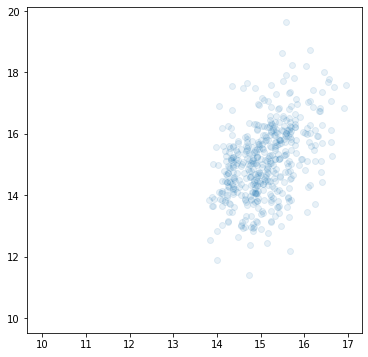

In [757]:
#predicted vs actual
test_set_pred_lm3 = fit3.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(test_set_pred_lm3, y_test, alpha=.1);
plt.plot(np.linspace(10,18,1), np.linspace(10,18,1));

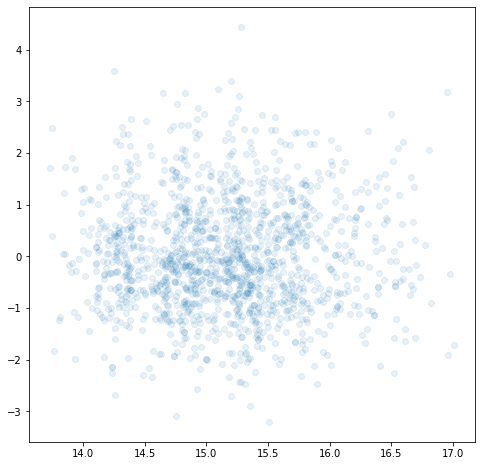

In [758]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(8,8))
plt.scatter(fit3.predict(), fit3.resid, alpha=0.1);

### Standardize

In [759]:
# #Standardize features
# std = StandardScaler()
# std.fit(X_train.values)

# X_tr = std.transform(X_train.values)

# X_te = std.transform(X_test.values)

# Only standardize non-categorical columns

#non-categorical columns
# col_names = ['number_of_discharges', 'Case_Mix_Indexes', 'FY_Wage_Index', 'median_household_income',
#              'some_college_or_higher','CMI2','nod2','FWI2','MHI2','SCH2','CMIxNOD', 'FWIxMHI', 'MHIxSCH']
# col_names = ['number_of_discharges', 'Case_Mix_Indexes', 'FY_Wage_Index', 'median_household_income',
#              'some_college_or_higher','CMI2','nod2','SCH2','CMIxNOD', 'FWIxMHI']
col_names=['number_of_discharges']
# col_names=[]

X_features = X[col_names]
X_train_features = X_train[col_names]
X_test_features = X_test[col_names]
X_val_features = X_val[col_names]

#pass through non-categorical columns
# ct = ColumnTransformer([
#         ('somename', StandardScaler(), ['number_of_discharges', 'Case_Mix_Indexes', 'FY_Wage_Index', 'median_household_income', 'some_college_or_higher','CMI2','nod2','FWI2','MHI2','SCH2','CMIxNOD', 'FWIxMHI', 'MHIxSCH'])], remainder='passthrough')
# ct = ColumnTransformer([
#         ('somename', StandardScaler(), ['number_of_discharges', 'Case_Mix_Indexes', 'FY_Wage_Index', 'median_household_income', 'some_college_or_higher','CMI2','nod2','SCH2','CMIxNOD', 'FWIxMHI'])
#     ], remainder='passthrough')
ct = ColumnTransformer([
        ('somename', StandardScaler(), ['number_of_discharges'])], remainder='passthrough')
# ct = ColumnTransformer([
#         ('somename', StandardScaler(), [])], remainder='passthrough')

ct.fit(X_train_features)

X_1 = ct.transform(X_features)
X_a = ct.transform(X_train_features)
X_b = ct.transform(X_test_features)
X_c = ct.transform(X_val_features)

#pull out the categorical from original data for concatenation with transformed
X_cat = np.array(X.drop(col_names,axis=1))
X_cat_train = np.array(X_train.drop(col_names,axis=1))
X_cat_test = np.array(X_test.drop(col_names,axis=1))
X_cat_val = np.array(X_val.drop(col_names,axis=1))

#concatenate back into one dataset
X_stan = np.concatenate((X_1,X_cat),axis=1) # full dataset
X_tr = np.concatenate((X_a,X_cat_train),axis=1)
X_te = np.concatenate((X_b,X_cat_test),axis=1)
X_va = np.concatenate((X_c,X_cat_val),axis=1)

# X_tr2 = pd.concat([X_a, X_cat_train], sort=False)
#
# X_a2 = pd.DataFrame(X_a,columns=col_names).reset_index().drop(['index'],axis=1)
# X_a3 = X_train.drop(col_names,axis=1).reset_index().drop(['index'],axis=1)
# X_a4 = X_a2.merge(X_a3, left_index=True, right_index=True)

In [760]:
# X_a4['effectiveness_of_care_national_comparison_Below_the_national_average'].value_counts()
# X_a4.info()

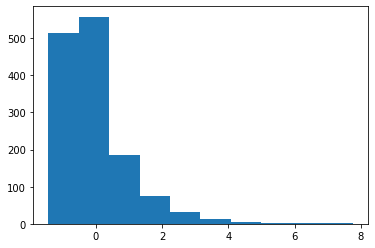

In [761]:
plt.hist(X_tr[:,0]);
# plt.hist(X_tr[:,19]);

### Ridge Regularization test

In [762]:
ridge_model = Ridge(alpha = 3) #found from manual validation alpha below
ridge_model.fit(X_tr, y_train)

list(zip(X_train.columns, ridge_model.coef_))

[('number_of_discharges', -0.08096876514267472),
 ('mortality_national_comparison_Below_the_national_average',
  -1.1952905184182339),
 ('mortality_national_comparison_Same_as_the_national_average',
  -0.8578222881721554),
 ('safety_of_care_national_comparison_Below_the_national_average',
  0.11100010434075903),
 ('safety_of_care_national_comparison_Same_as_the_national_average',
  -0.16337924800276693),
 ('patient_experience_national_comparison_Below_the_national_average',
  0.9358871912785742),
 ('patient_experience_national_comparison_Same_as_the_national_average',
  0.5303189245050103),
 ('effectiveness_of_care_national_comparison_Below_the_national_average',
  -0.06638704056159102),
 ('effectiveness_of_care_national_comparison_Same_as_the_national_average',
  -0.09303870954192911),
 ('timeliness_of_care_national_comparison_Below_the_national_average',
  0.4394613041219389),
 ('timeliness_of_care_national_comparison_Same_as_the_national_average',
  0.08601225396446542),
 ('efficien

In [763]:
# Make predictions on the test set using the new model
test_set_pred_r = ridge_model.predict(X_te)

In [764]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_r)

0.856922925170458

In [765]:
r2_score(y_test, test_set_pred_r)

0.18589807825778115

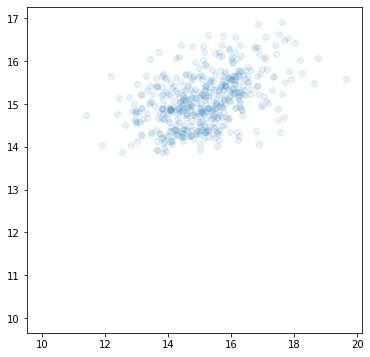

In [830]:
#actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, test_set_pred_r, alpha=.1);
plt.plot(np.linspace(10,20,1), np.linspace(10,20,1));

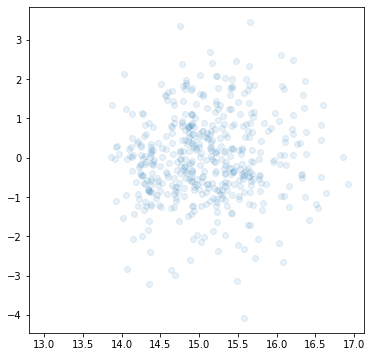

In [821]:
#predicted vs residuals
test_set_resid_r = test_set_pred_r-y_test
plt.figure(figsize=(6,6))
plt.scatter(test_set_pred_r, test_set_resid_r, alpha=.1);
plt.plot(np.linspace(13,18,1), np.linspace(-4,4,1));

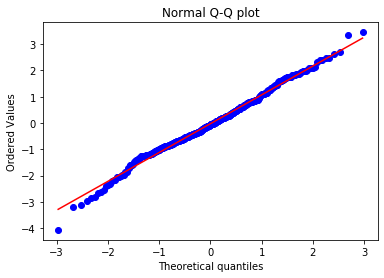

In [824]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(test_set_resid_r, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Lasso Regularization test

In [816]:
lasso_model = Lasso(alpha = 0.02)
lasso_model.fit(X_tr, y_train)

list(zip(X_train.columns, lasso_model.coef_))

[('number_of_discharges', -0.029845950305759802),
 ('mortality_national_comparison_Below_the_national_average',
  -0.8202231551823123),
 ('mortality_national_comparison_Same_as_the_national_average',
  -0.575889506588063),
 ('safety_of_care_national_comparison_Below_the_national_average',
  0.09759600066494005),
 ('safety_of_care_national_comparison_Same_as_the_national_average',
  -0.010077536086268891),
 ('patient_experience_national_comparison_Below_the_national_average',
  0.7582126016899525),
 ('patient_experience_national_comparison_Same_as_the_national_average',
  0.3215927533534784),
 ('effectiveness_of_care_national_comparison_Below_the_national_average', 0.0),
 ('effectiveness_of_care_national_comparison_Same_as_the_national_average',
  -0.0),
 ('timeliness_of_care_national_comparison_Below_the_national_average',
  0.3511313051927522),
 ('timeliness_of_care_national_comparison_Same_as_the_national_average', 0.0),
 ('efficient_use_of_medical_imaging_national_comparison_Below_t

In [767]:
# Make predictions on the test set using the new model
test_set_pred_l = lasso_model.predict(X_te)

In [768]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_l)

0.8505263475102829

In [769]:
r2_score(y_test, test_set_pred_l)

0.1963257443726215

# cross validation to find alpha

### manually w/ Ridge

In [770]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
#     steps = [('standardize', StandardScaler()), 
#              ('lasso', Lasso(alpha = curr_alpha))]
#     steps = [('lasso', Lasso(alpha = curr_alpha))]   
    steps = [('ridge', Ridge(alpha = curr_alpha))]
  
    pipe = Pipeline(steps)
    pipe.fit(X_tr, y_train)
    
    val_set_pred = pipe.predict(X_va) #changed this to standardized X_va dataset
    err_vec_val[i] = mae(y_val, val_set_pred)

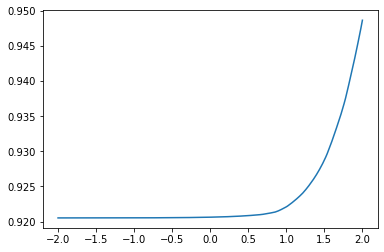

In [771]:
#plot the curve of validation error as alpha changes
plt.plot(np.log10(alphalist), err_vec_val);

In [772]:
np.min(err_vec_val)

0.920511011987374

In [773]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.01

### manually w/ Lasso

In [774]:
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
#     steps = [('standardize', StandardScaler()), 
#              ('lasso', Lasso(alpha = curr_alpha))]
    steps = [('lasso', Lasso(alpha = curr_alpha))]   
#     steps = [('ridge', Ridge(alpha = curr_alpha))]
  
    pipe = Pipeline(steps)
    pipe.fit(X_tr, y_train)
    
    val_set_pred = pipe.predict(X_va) #changed this to standardized X_va dataset
    err_vec_val[i] = mae(y_val, val_set_pred)

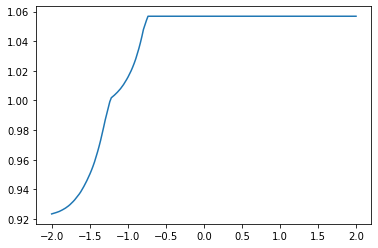

In [775]:
#plot the curve of validation error as alpha changes
plt.plot(np.log10(alphalist), err_vec_val);

In [776]:
np.min(err_vec_val)

0.9234584726632094

In [777]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.01

### w/ RidgeCV

In [778]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
from sklearn.model_selection import GridSearchCV
alphavec = 10**np.linspace(-2,2,200)

a = {'alpha':alphavec}
ridge_model2 = GridSearchCV(Ridge(), param_grid=a, cv=5)
ridge_model2.fit(X_tr, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [779]:
# ridge_model2.alpha_
ridge_model2.best_estimator_.alpha

3.107866187782014

In [780]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
# list(zip(X_train.columns, ridge_model2.coef_))

In [781]:
# Make predictions on the test set using the new model
test_set_pred_r2 = ridge_model2.predict(X_te)

In [782]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_r2)

0.856862085576221

In [783]:
r2_score(y_test, test_set_pred_r2)

0.18597949692885907

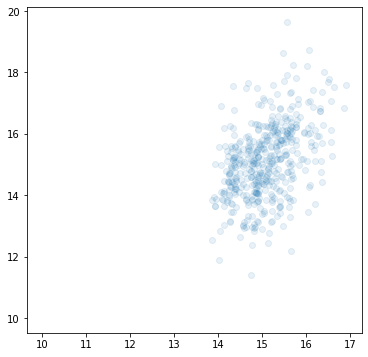

In [784]:
#ridge model
plt.figure(figsize=(6,6))
plt.scatter(test_set_pred_r2, y_test, alpha=.1);
plt.plot(np.linspace(10,18,1), np.linspace(10,18,1));

### w/ LassoCV

In [785]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

# lasso_model2 = LassoCV(alphas = alphavec, cv=5)
# lasso_model2.fit(X_tr, y_train)

a = {'alpha':alphavec}
lasso_model2 = GridSearchCV(Lasso(), param_grid=a, cv=5)
lasso_model2.fit(X_tr, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.203...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [786]:
lasso_model2.best_estimator_.alpha

0.01

In [787]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
# list(zip(X_train.columns, lasso_model2.coef_))

In [788]:
# Make predictions on the test set using the new model
test_set_pred_l2 = lasso_model2.predict(X_te)

In [789]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_l2)

0.8505263475102829

In [790]:
r2_score(y_test, test_set_pred_l2)

0.1963257443726215

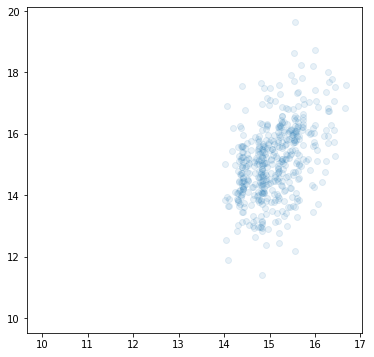

In [791]:
#lasso model - actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(test_set_pred_l2, y_test, alpha=.1);
plt.plot(np.linspace(10,18,1), np.linspace(10,18,1));

In [792]:
# Lars path visualization
# std = StandardScaler()
# std.fit(X_train.values)
# X_tr = std.transform(X_train.values)

## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')


Computing regularization path using the LARS ...


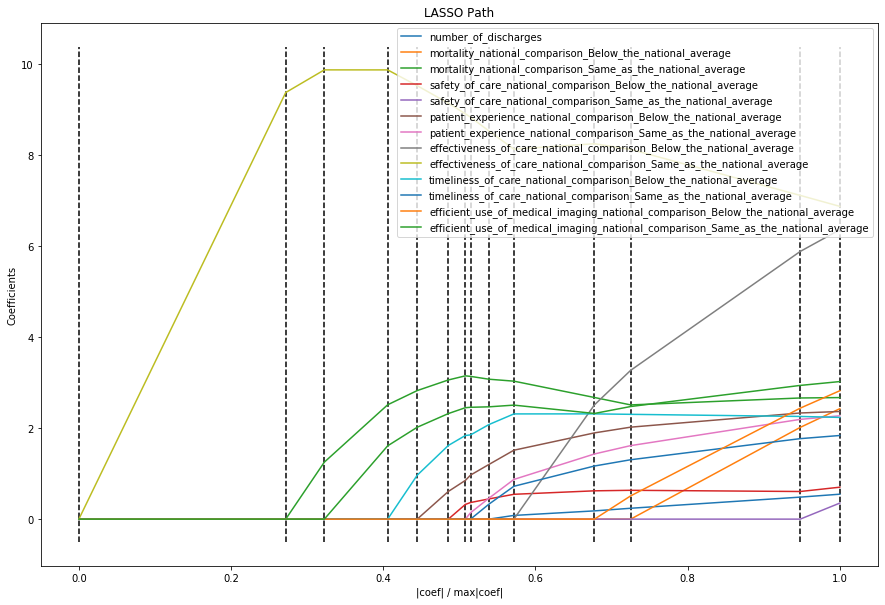

In [793]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(15,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns, loc = 'upper right')
plt.show()

### Graphing

In [794]:
# #linear model


In [795]:
# r2_score(y_test, test_set_pred)

In [796]:
# mae(y_test, test_set_pred)

# Validate

### Validation w/o K-fold

In [797]:
#the model is fit well with train and test but very poorly with val - why?

lm_a = LinearRegression()
lm_a.fit(X_train,y_train)

print(f'Linear Regression val R^2 - train: {lm_a.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2 - val: {lm_a.score(X_val, y_val):.3f}')

Linear Regression val R^2 - train: 0.250
Linear Regression val R^2 - val: 0.193


In [798]:
#Ridge Regression
print(f'Ridge Regression v1 val R^2: {ridge_model.score(X_va, y_val):.3f}')
#RidgeCV model
print(f'Ridge Regression v2 val R^2: {ridge_model2.score(X_va, y_val):.3f}')

Ridge Regression v1 val R^2: 0.193
Ridge Regression v2 val R^2: 0.193


In [799]:
#Lasso Regression
print(f'Lasso Regression v1 val R^2: {lasso_model.score(X_va, y_val):.3f}')
#LassoCV model
print(f'Lasso Regression v2 val R^2: {lasso_model2.score(X_va, y_val):.3f}')

Lasso Regression v1 val R^2: 0.191
Lasso Regression v2 val R^2: 0.191


In [800]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [801]:
#validate
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.193
Ridge Regression val R^2: 0.193
Degree 2 polynomial regression val R^2: 0.163


In [802]:
lm.fit(X, y)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')


Linear Regression val R^2: 0.207


# K Fold

In [803]:
lm = LinearRegression()
lm_ridge = Ridge(alpha=3.255)
lm_lasso = Lasso(alpha=0.01)

In [804]:
#Linear
cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.15429414, 0.2902651 , 0.23237594, 0.16289837, 0.24891998])

In [805]:
#Ridge
cross_val_score(lm_ridge, X_stan, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.15698728, 0.28836818, 0.23103671, 0.16591278, 0.24802007])

In [806]:
#Lasso
cross_val_score(lm_lasso, X_stan, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.17011659, 0.27697577, 0.22390222, 0.17130361, 0.23929764])

In [807]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.24600204, 0.13354602, 0.22786568, 0.27553824, 0.1972208 ])

In [808]:
kf = KFold(n_splits=5, shuffle=True)

print(f"Linear Regression mean val R^2: {np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')):.4f}")
print(f"Ridge Regression mean val R^2: {np.mean(cross_val_score(lm_ridge, X_stan, y, cv=kf, scoring='r2')):.4f}")
print(f"Lasso Regression mean val R^2: {np.mean(cross_val_score(lm_lasso, X_stan, y, cv=kf, scoring='r2')):.4f}")

Linear Regression mean val R^2: 0.2219
Ridge Regression mean val R^2: 0.2254
Lasso Regression mean val R^2: 0.2139


In [809]:
# find coeffs:
lm_ridge.fit(X_stan,y)
lm_ridge.coef_

array([-0.08021655, -1.26515498, -0.89055223,  0.14643979, -0.16220454,
        0.87685306,  0.45881029, -0.06344527, -0.00624514,  0.46439848,
        0.11572193,  0.32325553,  0.09042024])

In [810]:
# find coeffs:
lm_ridge.fit(X_tr,y_train)
lm_ridge.coef_

array([-0.080778  , -1.19128698, -0.85506403,  0.11115488, -0.16299549,
        0.93431239,  0.52890946, -0.0653899 , -0.09232008,  0.43937396,
        0.08571328,  0.37915283,  0.10138646])

# Check linear assumptions

### Residuals normally distributed with zero mean

In [811]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis

# data['predict']=fit.predict(X)
# data['resid']=data.cnt-data.predict
# with sns.axes_style('white'):
#     plot=data.plot(kind='scatter',
#                   x='predict',y='resid',alpha=0.2,figsize=(10,6))

In [812]:
# inspect histogram
# data.cnt.hist(bins=35)
# plt.title('Histogram of Dependent Variable (User Counts)');

In [813]:
# # diagnose/inspect residual normality using qqplot:
# stats.probplot(data['resid'], dist="norm", plot=plt)
# plt.title("Normal Q-Q plot")
# plt.show()

### Assumption 3: error terms must have constant variance

### Assumption 4: errors are uncorrelated across observations

### Assumption 5: no independent variable is a perfect linear function of any other independent variable (no perfect multi-collinearity)

In [814]:
#assume this is fixed with Ridge regression model

# Pick final coefficients and run with statsmodel

In [815]:
# lm3 = sm.OLS(y_train,X_train)
select_columns = all_columns

lm4 = smf.ols('avg_PRR ~' + select_columns, data=X_train_check)
# Fit the model
fit4 = lm4.fit()
# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     35.25
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           8.80e-77
Time:                        18:35:33   Log-Likelihood:                -2085.6
No. Observations:                1392   AIC:                             4199.
Df Residuals:                    1378   BIC:                             4272.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================
                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                            15.2768      0.194     78.935      0.000      14.897      15.656
number_of_discharges                                                              -6.835e-05   2.77e-05     -2.472      0.014      -0.000   -1.41e-05
mortality_national_comparison_Below_the_national_average                             -1.2445      0.110    -11.359      0.000      -1.459      -1.030
mortality_national_comparison_Same_as_the_national_average                           -0.8917      0.087    -10.253      0.000      -1.062      -0.721
safety_of_care_national_comparison_Below_the_national_average                         0.1091      0.067      1.638      0.102      -0.022       0.240
safety_of_care_national_comparison_Same_as_the_national_average                      -0.1680      0.083     -2.020      0.044      -0.331      -0.005
patient_experience_national_comparison_Below_the_national_average                     0.9550      0.078     12.171      0.000       0.801       1.109
patient_experience_national_comparison_Same_as_the_national_average                   0.5474      0.078      7.062      0.000       0.395       0.699
effectiveness_of_care_national_comparison_Below_the_national_average                 -0.0794      0.158     -0.504      0.614      -0.388       0.230
effectiveness_of_care_national_comparison_Same_as_the_national_average               -0.1024      0.122     -0.839      0.402      -0.342       0.137
timeliness_of_care_national_comparison_Below_the_national_average                     0.4404      0.086      5.137      0.000       0.272       0.609
timeliness_of_care_national_comparison_Same_as_the_national_average                   0.0896      0.080      1.121      0.262      -0.067       0.246
efficient_use_of_medical_imaging_national_comparison_Below_the_national_average       0.3918      0.103      3.804      0.000       0.190       0.594
efficient_use_of_medical_imaging_national_comparison_Same_as_the_national_average     0.1084      0.082      1.320      0.187      -0.053       0.270
==============================================================================
Omnibus:                       29.880   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.261
Skew:                           0.356   Prob(JB):                     1.63e-07
Kurtosis:                       3.180   Cond. No.                     2.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance m

### Partial least squares

In [848]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=2, scale=False)
pls.fit(X_tr, y_train)

# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True,
#         tol=1e-06)
y_pred = pls.predict(X_te)

In [849]:
#R squared
pls.score(X_te,y_test)

0.15493909673195427